In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from nltk.tokenize import sent_tokenize
from keras import layers, models, optimizers
import csv



In [41]:
import pandas as pd
import numpy as np

In [42]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import random

[nltk_data] Downloading package punkt to /Users/james/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
csv.field_size_limit(999999)
train = pd.read_csv('raw_data/fulltrain.csv', header = None, names=['class','text'])
test = pd.read_csv("raw_data/balancedtest.csv", header = None, names=['class','text'])

In [44]:
train['class'].value_counts()

class
3    17870
1    14047
4     9995
2     6942
Name: count, dtype: int64

In [45]:
one = train.loc[train['class'] == 1]
two = train.loc[train['class'] == 2]
three = train.loc[train['class'] == 3]
four = train.loc[train['class'] == 4]

In [46]:
train = pd.concat([train, one.sample(n=3953), two.sample(n=6000), two.sample(n=5058), three.sample(n=130), four.sample(n=8005)], ignore_index=True)


In [47]:
train['class'].value_counts()

class
1    18000
2    18000
3    18000
4    18000
Name: count, dtype: int64

In [48]:
x_train = train['text']
x_test = test['text']

In [49]:
tokenizer = Tokenizer(num_words=700)
tokenizer.fit_on_texts(x_train.values)
word_index = tokenizer.word_index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding
padding_type = 'post'
truncating_type = 'post'

In [50]:
vocab_size = len(word_index) + 1
max_length = 1000

X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)


In [51]:
vocab_size = len(word_index) + 1                          

maxlen = 1000

X_train = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
X_test = pad_sequences(test_sequences, padding='post', maxlen=maxlen)

In [52]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate




In [53]:
def create_embedding_matrix(word_vectors, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word_index.items():
        if word in word_vectors:
            embedding_matrix[idx] = word_vectors[word]
    return embedding_matrix

# Load Word2Vec KeyedVectors
word2vec_path = 'word2vec-google-news-300.model'  # Adjust as needed
word2vec = KeyedVectors.load(word2vec_path)

embedding_dim = 300  
embedding_matrix = create_embedding_matrix(word2vec, tokenizer.word_index, embedding_dim)



In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Adjust the number of max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(x_train)  # Replace 'your_text_data' with your actual text data
tfidf_feature_length = tfidf_matrix.shape[1]  # Number of TF-IDF features

In [56]:
y_train = train['class'] - 1
y_test = test['class'] - 1

In [57]:
num_classes = 4
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [58]:
y_test_categorical

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [59]:
sequence_input = Input(shape=(max_length,), dtype='int32')
tfidf_input = Input(shape=(tfidf_feature_length,))

In [60]:
import tensorflow as tf
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],  # Vocabulary size
                            output_dim=embedding_matrix.shape[1],  # Embedding dimensionality
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # Use pre-trained weights
                            input_length=max_length,  # Length of input sequences
                            trainable=False)(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedding_layer)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
cnn_path = x


/Users/james/Documents/NUS/Y2S2/CS4248/Labeled-Unreliable-News/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [61]:
y = Dense(128, activation='relu')(tfidf_input)
tfidf_path = Dropout(1)(y)


In [62]:
from tensorflow.keras.layers import Concatenate

# combined = Concatenate()([cnn_path, tfidf_path])

In [63]:
# Output layer
output = Dense(4, activation='softmax')(cnn_path)

# Create and compile the model
model = Model(inputs=[sequence_input, tfidf_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])


In [64]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1000, 300) │ 77,786,100 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 996, 128)  │    192,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      4,128 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │        132 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,982,488 (297.48 MB)

 Trainable params: 196,388 (767.14 KB)

 Non-trainable params: 77,786,100 (296.73 MB)

In [65]:
X_train_sequences = tokenizer.texts_to_sequences(x_train)  # Replace with your training text data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_train_tfidf = tfidf_vectorizer.transform(x_train).toarray()  # Replace with your training text data


In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


In [67]:
X_test_sequences = tokenizer.texts_to_sequences(x_test)  # Replace with your training text data
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)
X_test_tfidf = tfidf_vectorizer.transform(x_test).toarray() 

In [68]:
model1 = model

In [69]:
model.fit([X_train_padded, X_train_tfidf], y_train_categorical, batch_size=128, epochs=30, validation_data=([X_test_padded, X_test_tfidf], y_test_categorical), callbacks=[early_stopping])


Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 190s 336ms/step - accuracy: 0.8517 - loss: 0.4332 - val_accuracy: 0.5883 - val_loss: 1.2894
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 195s 346ms/step - accuracy: 0.9792 - loss: 0.0730 - val_accuracy: 0.5440 - val_loss: 1.7887
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 189s 336ms/step - accuracy: 0.9938 - loss: 0.0288 - val_accuracy: 0.5907 - val_loss: 1.7806
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 195s 347ms/step - accuracy: 0.9982 - loss: 0.0110 - val_accuracy: 0.5663 - val_loss: 2.3069
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 189s 336ms/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.5710 - val_loss: 2.4769
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 191s 339ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.5787 - val_loss: 2.5396
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [70]:
model1.fit([X_train_padded, X_train_tfidf], y_train_categorical, batch_size=128, epochs=30, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 179s 352ms/step - accuracy: 0.9717 - loss: 0.0871 - val_accuracy: 0.9918 - val_loss: 0.0303
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 177s 350ms/step - accuracy: 0.9934 - loss: 0.0256 - val_accuracy: 0.9958 - val_loss: 0.0145
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 179s 353ms/step - accuracy: 0.9979 - loss: 0.0114 - val_accuracy: 0.9965 - val_loss: 0.0157
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 174s 344ms/step - accuracy: 0.9988 - loss: 0.0057 - val_accuracy: 0.9982 - val_loss: 0.0072
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 173s 340ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9981 - val_loss: 0.0056
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 173s 341ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 179s 354ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9986 - val_loss: 0.0051
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 180s 355ms/step - accuracy: 0.9994 -

In [71]:
y_pred = model.predict([X_test_padded, X_test_tfidf])
y_pred_classes = y_pred.argmax(axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [72]:
y_pred1 = model1.predict([X_test_padded, X_test_tfidf])
y_pred1_classes = y_pred1.argmax(axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [73]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [74]:
score = f1_score(y_test, y_pred_classes, average='macro')
print('Score on validation = {}'.format(score))

Score on validation = 0.5719811936407269


In [75]:
print('Classification report on test data:')
# Make sure y_test is in the correct format for comparison
print(classification_report(y_test, y_pred_classes))

Classification report on test data:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       750
           1       0.63      0.39      0.48       750
           2       0.43      0.46      0.44       750
           3       0.58      0.92      0.71       750

    accuracy                           0.58      3000
   macro avg       0.60      0.58      0.57      3000
weighted avg       0.60      0.58      0.57      3000



In [76]:
score = f1_score(y_test, y_pred1_classes, average='macro')
print('Score on validation = {}'.format(score))

Score on validation = 0.5719811936407269


In [77]:
print('Classification report on test data:')
# Make sure y_test is in the correct format for comparison
print(classification_report(y_test, y_pred1_classes))

Classification report on test data:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       750
           1       0.63      0.39      0.48       750
           2       0.43      0.46      0.44       750
           3       0.58      0.92      0.71       750

    accuracy                           0.58      3000
   macro avg       0.60      0.58      0.57      3000
weighted avg       0.60      0.58      0.57      3000



In [82]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred1_classes)
print(cm)

[[420 161  70  99]
 [ 37 294 369  50]
 [ 49   3 344 354]
 [ 33   7  21 689]]


In [1]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_pred1_classes, average='macro'))
print(recall_score(y_test, y_pred1_classes, average='macro'))

NameError: name 'y_test' is not defined

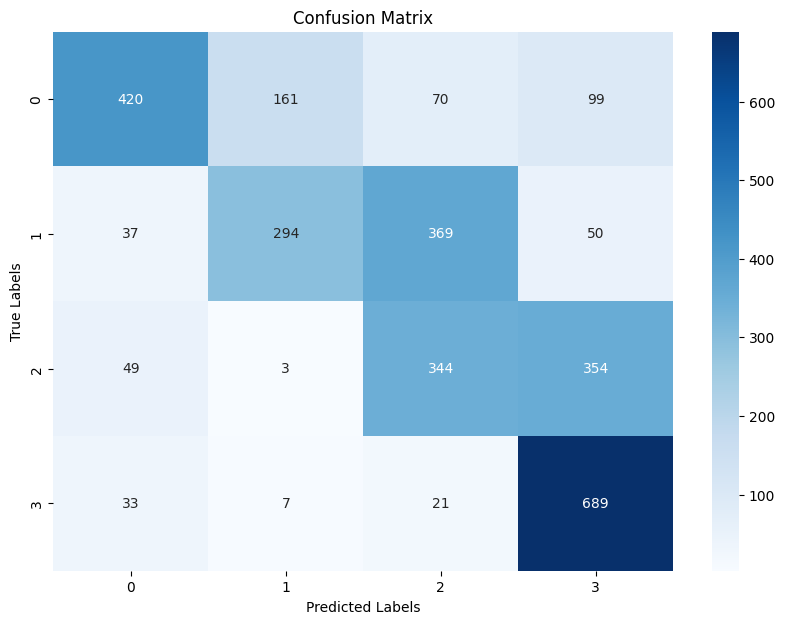

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()